**Temas Selectos de Ingenieria III**
# Sebastián González Juárez
Practica 3.

Paqueterías:

In [45]:
!pip -q install qiskit pylatexenc

In [46]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.providers.basic_provider import BasicSimulator
from IPython.display import display
import numpy as np
from qiskit.circuit.library import XGate, ZGate

# 1. Codifica una función llamada teleportacion que cumpla con lo siguiente:


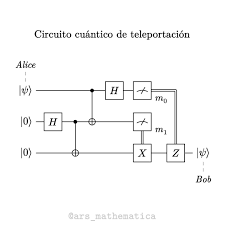

Simulador SIN usar qiskit-aer, usando: BasicSimulator.

In [47]:
def obtener_backend_basico():
    try:
        # Qiskit >= 0.45: BasicProvider con "basic_simulator"
        from qiskit.providers.basic_provider import BasicProvider
        proveedor = BasicProvider()
        return proveedor.get_backend("basic_simulator")
    except Exception:
        # Compatibilidad (no es Aer). Si no está BasicSimulator, usamos BasicAer (integrado en Terra).
        from qiskit import BasicAer
        return BasicAer.get_backend("qasm_simulator")

backend_basico = obtener_backend_basico()

Con la sig. fun. preparamos |ψ> en 'qubit', de 2 formas:
   1) Paramétrica: |ψ> = cos(theta/2)|0> + e^{i phi} sin(theta/2)|1>
         (pasa angulo_theta y angulo_phi)
   2) Predefinidos: '0','1','+','-','+i','-i'

In [48]:
def preparar_estado_un_qubit(circuito, qubit, angulo_theta=None, angulo_phi=None, nombre_predefinido=None):
    if nombre_predefinido is not None:
        if nombre_predefinido == '0':
            pass
        elif nombre_predefinido == '1':
            circuito.x(qubit)
        elif nombre_predefinido == '+':
            circuito.h(qubit)
        elif nombre_predefinido == '-':
            circuito.x(qubit); circuito.h(qubit); circuito.z(qubit)
        elif nombre_predefinido == '+i':
            circuito.h(qubit); circuito.s(qubit)  # |+i> = S H |0>
        elif nombre_predefinido == '-i':
            circuito.h(qubit); circuito.sdg(qubit) # |-i> = S† H |0>
        else:
            raise ValueError("Estado predefinido no reconocido. Usa: '0','1','+','-','+i','-i'.")
    else:
        if angulo_theta is None or angulo_phi is None:
            raise ValueError("Faltan ángulos para el modo paramétrico.")
        # U(θ, φ, 0) prepara cos(θ/2)|0> + e^{iφ} sin(θ/2)|1> a partir de |0>
        circuito.u(angulo_theta, angulo_phi, 0, qubit)

Praparación del estado de Bell entre los qubits de Alicia y Bob:

In [49]:
def preparar_par_bell(circuito, qa, qb, tipo_bell='Phi+'):
    circuito.h(qa)
    circuito.cx(qa, qb)
    if   tipo_bell == 'Phi+':
        pass
    elif tipo_bell == 'Phi-':
        circuito.z(qb)
    elif tipo_bell == 'Psi+':
        circuito.x(qb)
    elif tipo_bell == 'Psi-':
        circuito.x(qb); circuito.z(qb)
    else:
        raise ValueError("Tipo Bell no reconocido.")

Correcciones de Bob:

In [50]:
def correccion_por_tipo_bell(circuito, qb, tipo_bell='Phi+'):
    if   tipo_bell == 'Phi+':
        pass
    elif tipo_bell == 'Phi-':
        circuito.z(qb)
    elif tipo_bell == 'Psi+':
        circuito.x(qb)
    elif tipo_bell == 'Psi-':
        circuito.x(qb); circuito.z(qb)

Dibujo de esfera de Bloch:

In [51]:
def bloch_de_statevector(statevector, titulo="Esfera de Bloch"):
    figura = plot_bloch_multivector(statevector)
    figura.suptitle(titulo)
    display(figura)

Parámetros globales:

In [52]:
# ---- Estado a enviar ----
modo_estado = 'predefinido'   # 'predefinido' o 'parametrico'
nombre_predefinido = '+'      # si 'predefinido': '0','1','+','-','+i','-i'
angulo_theta = np.pi/2        # si 'parametrico'
angulo_phi   = np.pi/3        # si 'parametrico'

# ---- Par de Bell ----
tipo_bell = 'Phi+'            # 'Phi+','Phi-','Psi+','Psi-'

# ---- Visualización / Simulación ----
dibujar_mpl = True
tiros = 1024
semilla = 1234

**A. Reciba parámetros para preparar el estado a ser teleportado.**

In [53]:
q = QuantumRegister(3, 'q')
circuito = QuantumCircuit(q, name='teleportacion_A_F')

Preparamos el estado de referencia |ψ> como Statevector (para mostrar Bloch y verificación)

In [54]:
if modo_estado == 'predefinido':
    preparar_estado_un_qubit(circuito, q[0], nombre_predefinido=nombre_predefinido)
    circ_ref = QuantumCircuit(1)
    preparar_estado_un_qubit(circ_ref, 0, nombre_predefinido=nombre_predefinido)
    estado_a_enviar = Statevector.from_instruction(circ_ref)
else:
    preparar_estado_un_qubit(circuito, q[0], angulo_theta=angulo_theta, angulo_phi=angulo_phi)
    circ_ref = QuantumCircuit(1)
    preparar_estado_un_qubit(circ_ref, 0, angulo_theta=angulo_theta, angulo_phi=angulo_phi)
    estado_a_enviar = Statevector.from_instruction(circ_ref)

**B. Reciba otro parámetro que indique que estado de Bell se debe usar para entrelazar los qubits de Alicia y de Bob. Preparar el estado de Bell correspondiente.**

Par de Bell entre q1 (Alicia) y q2 (Bob)

In [55]:
preparar_par_bell(circuito, q[1], q[2], tipo_bell=tipo_bell)
print(tipo_bell)

Phi+


**C. Aplique las compuertas correctas en la decodificación dependiendo del estado de Bell indicado como parámetro.**

CNOT q0->q1 y H en q0

In [56]:
circuito.cx(q[0], q[1])
circuito.h(q[0])

Correcciones estándar en Bob (equivalen a X^{m2} y Z^{m1}):

In [57]:
circuito.cx(q[1], q[2])  # X controlado por q1
circuito.cz(q[0], q[2])  # Z controlado por q0

correccion_por_tipo_bell(circuito, q[2], tipo_bell=tipo_bell)

**D. Muestre el circuito creado con el protocolo de Teleportación completo con los parámetros provistos.**
* Recuerda que puedes usar la función display para que el .draw() del circuito se vea (hay ejemplos de esto en los notebooks).

In [58]:
display(circuito.draw('text'))

┌───┐          ┌───┐   
q_0: ┤ H ├───────■──┤ H ├─■─
     ├───┤     ┌─┴─┐└───┘ │ 
q_1: ┤ H ├──■──┤ X ├──■───┼─
     └───┘┌─┴─┐└───┘┌─┴─┐ │ 
q_2: ─────┤ X ├─────┤ X ├─■─
          └───┘     └───┘

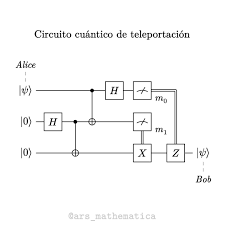

**E.** Muestre una esfera de Bloch con el estado a ser enviado (usar función display). El estado lo puedes obtener con Statevector (ver Lab1).

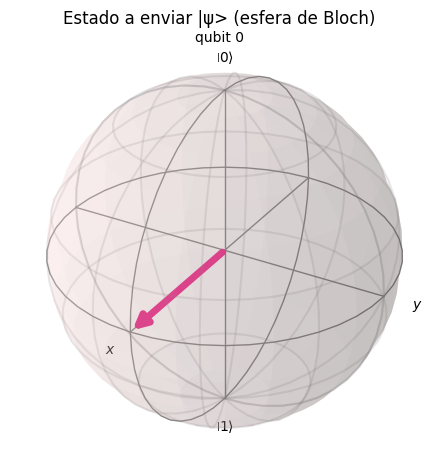

In [59]:
bloch_de_statevector(estado_a_enviar, titulo="Estado a enviar |ψ> (esfera de Bloch)")

Verificar:

In [60]:
sv_final = Statevector.from_instruction(circuito)
rho_global = DensityMatrix(sv_final)
rho_bob = partial_trace(rho_global, [0, 1])         # trazamos fuera a Alicia (q0 y q1)
rho_objetivo = DensityMatrix(estado_a_enviar)
fidelidad = (rho_bob.data.conj() * rho_objetivo.data).sum().real  # tr(rho_bob * rho_objetivo)
print(f"Fidelidad entre el estado de Bob y |ψ>: {fidelidad:.6f}  (≈1 esperado)")

Fidelidad entre el estado de Bob y |ψ>: 1.000000  (≈1 esperado)


**F.** Simulación del circuito usando la clase BasicSimulator (como en el ejemplo de este Lab3).

* Está prohibido usar Qiskit Aer (qiskit-aer). Muchos ejemplos en internet usan Qiskit Aer, pero no se puede usar en las tareas, así que realiza la adecuación pertinente del código.
* Muestra el histograma como en el ejemplo de este mismo notebook para comprobar los resultados a través de la simulación.

Cuentas clásicas de (q0,q1):


{'11': 248, '01': 248, '00': 262, '10': 266}

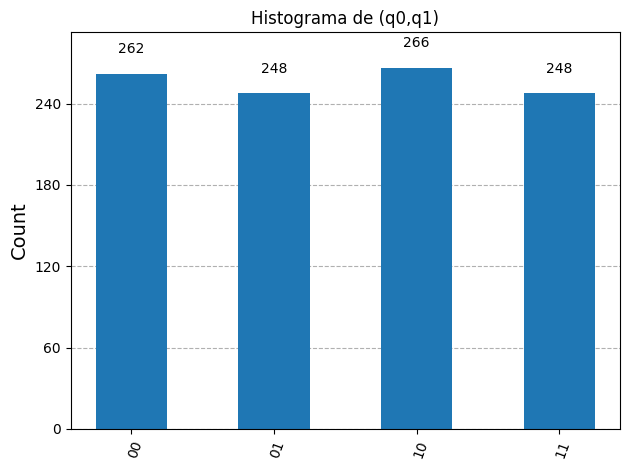

In [61]:
circuito_con_medidas = circuito.copy()
c = ClassicalRegister(2, 'c')
circuito_con_medidas.add_register(c)
circuito_con_medidas.measure([q[0], q[1]], [c[0], c[1]])

trabajo = backend_basico.run(circuito_con_medidas, shots=tiros, seed_simulator=semilla)
resultado = trabajo.result()
cuentas = resultado.get_counts()

print("Cuentas clásicas de (q0,q1):")
display(cuentas)
display(plot_histogram(cuentas, title="Histograma de (q0,q1)"))

# 2. Implementa las funciones cuánticas And y Or usando la estrategía vista en clase.

**A.** Muestra el circuito cuántico correspondiente.

* **Oráculo AND:
𝑡
←
𝑡
⊕
(
𝑎
∧
𝑏
)
t←t⊕(a∧b)**

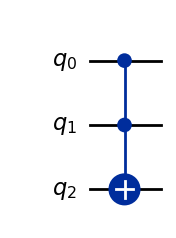

In [62]:
def oracle_AND():
    q = QuantumRegister(3, "q")   # q[0]=a, q[1]=b, q[2]=t
    qc = QuantumCircuit(q, name="U_AND")
    qc.ccx(q[0], q[1], q[2])
    return qc
display(oracle_AND().draw("mpl"))

* **Oráculo OR:
𝑡
←
𝑡
⊕
(
𝑎
∨
𝑏
)
t←t⊕(a∨b)**

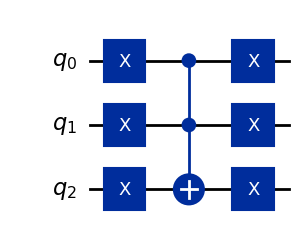

In [63]:
def oracle_OR():
    q = QuantumRegister(3, "q")   # q[0]=a, q[1]=b, q[2]=t
    qc = QuantumCircuit(q, name="U_OR")
    qc.x(q[2])
    qc.x(q[0]); qc.x(q[1])
    qc.ccx(q[0], q[1], q[2])
    qc.x(q[0]); qc.x(q[1])
    qc.x(q[2])
    return qc
display(oracle_OR().draw("mpl"))

**B.** Aplica tu circuito a un estado en superposición y exhibe el paralelismo cuántico. Muestra el circuito correspondiente

In [64]:
def apply_oracle_in_superposition(oracle_builder, shots=4096, title=""):
    # Registros
    q = QuantumRegister(3, "q")   # q0=a, q1=b, q2=t
    c = ClassicalRegister(3, "c") # c0<=a, c1<=b, c2<=t
    qc = QuantumCircuit(q, c, name=f"{title}_on_plusplus")

    # |+> en a,b
    qc.h(q[0]); qc.h(q[1])

    U = oracle_builder()
    qc.compose(U, q, inplace=True)

    # Medir a,b,t
    qc.measure(q[0], c[0])
    qc.measure(q[1], c[1])
    qc.measure(q[2], c[2])

    # Mostrar circuito
    display(qc.draw("mpl"))

    # Simulación
    backend = BasicSimulator()
    result = backend.run(qc, shots=shots).result()
    counts = result.get_counts(qc)
    display(plot_histogram(counts, title=title))
    return counts


Demostración: AND en superposición

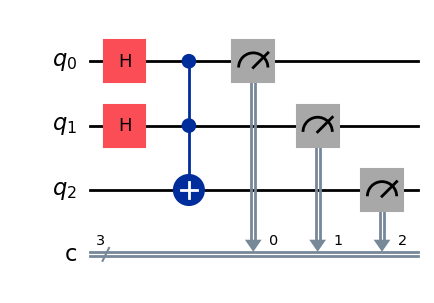

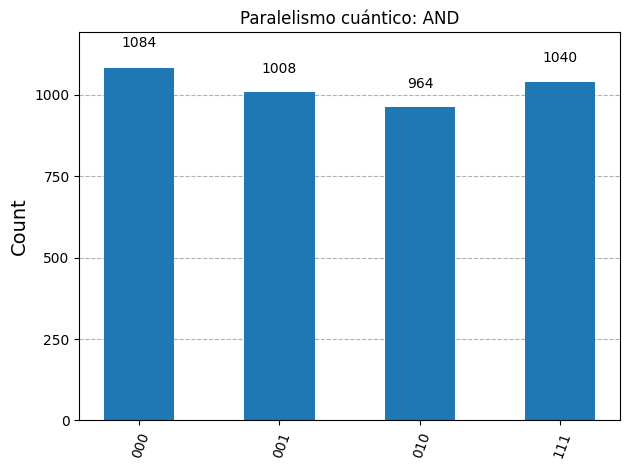

{'010': 964, '111': 1040, '001': 1008, '000': 1084}

In [65]:
counts_and = apply_oracle_in_superposition(oracle_builder=oracle_AND,
                                           shots=4096,
                                           title="Paralelismo cuántico: AND")
counts_and

Demostración: OR en superposición

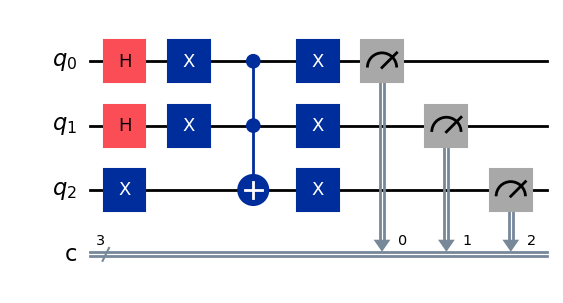

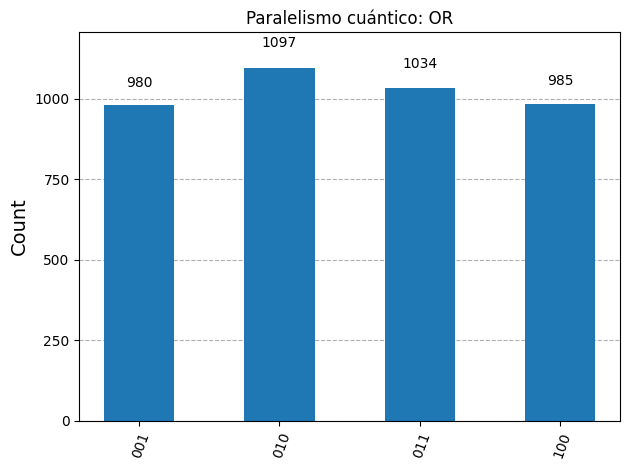

{'001': 980, '100': 985, '011': 1034, '010': 1097}

In [66]:
counts_or = apply_oracle_in_superposition(oracle_builder=oracle_OR,
                                          shots=4096,
                                          title="Paralelismo cuántico: OR")
counts_or